## Project Overview: 
In 2012, CMS began reducing Medicare payments for subsection(d) hospitals with excess readmissions under the Hospital Readmission Reduction Program. Excess readmissions are measured by a ratio, calculated by dividing a hospital's predicted Readmission Rate (RR) for heart attack, heart failure, pneumonia, chronic obstructive pulmonary disease, hip/knee replacement, and coronary artery bypass graft surgery by expected RR, based on an average hospital with similar patients.

We have been approached by leadership of a medium-large sized (approx. 2700 Medicare reimbursed inpatient cases per year) public hospital in New Jersey. In their annual review, CMS flagged the hospital as having a higher than expected RR and informed them they would be subject to reduced payments in 1 year if this rate (approx. 17%) did not improve by 1% to align with what CMS expects given their own model’s assumptions. 
 
The hospital’s leadership wants us to help then conduct their own analysis of factors most related to RR in hospitals of comparable size, and then come up with an evidence-driven plan to avoid a penalty that they have determined would substantially affect their ability to provide quality care. Even if the analysis reveals that factors largely out of their control (e.g., demographics in the area of the hospital, case volume, case mix) are responsible for their higher than expected RR rate according to CMS, the hospital administrators feel that this can be baked into a reply letter to CMS that may help forestall a reduction in Medicare reimbursement that would certainly negatively impact care at the facility.

In the previous step (see workbook 01_CleaningWrangling), we cleaned and wrangled data into several discrete dataframes. 

## Exploratory Data Analysis

### 1. Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder #to handle categorical variables (ED_Volume)
from sklearn.preprocessing import OneHotEncoder
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import scale

### 2. Load Data
Main data table and additional data from cleaning and wrangling - includes candidate predictive features and target feature (readmission rate) 

In [2]:
main_data = pd.read_csv('../data/main_df_post1.csv')
supp_data = pd.read_csv('../data/other_data_post1.csv')

### 3. Summaries of data

In [3]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Facility_ID           1006 non-null   object 
 1   City                  1006 non-null   object 
 2   State                 1006 non-null   object 
 3   County                1006 non-null   object 
 4   Total_Admissions      1006 non-null   int64  
 5   ReadmissionRate       1006 non-null   float64
 6   HAI_1_SIR             992 non-null    float64
 7   HAI_2_SIR             994 non-null    float64
 8   HAI_5_SIR             943 non-null    float64
 9   HAI_6_SIR             947 non-null    float64
 10  PSI_3                 1005 non-null   float64
 11  PSI_6                 1005 non-null   float64
 12  PSI_8                 1005 non-null   float64
 13  PSI_9                 1005 non-null   float64
 14  PSI_10                996 non-null    float64
 15  PSI_11               

In [4]:
main_data.head()

,Facility_ID,City,State,County,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,HAI_6_SIR,...,HIPKNEE_TA_PROP,PN_TA_PROP,ED_MEDIAN_VISIT_MINS,ED_LEFT_NOT_SEEN_%,ED_VOLUME,%_SEPSIS_CARE,%_HCWs_FLU_VAX,2018to2020_PCPI,Population_2019,MEDIAN_AGE_TOT
0,010001,DOTHAN,AL,Houston,1805,15.5,0.555,0.289,0.871,0.604,...,0.091413,0.278670,168.0,3.0,high,60.0,99.0,44661.000000,105882.0,40.0
1,010006,FLORENCE,AL,Lauderdale,1563,15.7,0.987,0.442,1.232,0.212,...,0.195777,0.424184,182.0,1.0,high,32.0,82.0,38525.333333,92729.0,41.6
2,010023,MONTGOMERY,AL,Montgomery,1165,15.0,2.080,1.568,2.985,0.638,...,0.345923,0.150215,185.0,NaN,NaN,11.0,93.0,45271.666667,226486.0,36.8
3,010024,MONTGOMERY,AL,Montgomery,1011,16.1,1.537,0.974,2.191,1.168,...,0.205737,0.348170,126.0,1.0,very high,73.0,53.0,45271.666667,226486.0,36.8
4,010029,OPELIKA,AL,Lee,1196,14.8,1.030,0.920,0.946,0.662,...,0.453177,0.296823,200.0,NaN,NaN,65.0,89.0,40363.666667,164542.0,32.8


In [5]:
#A quick look at distributions of feature values for the numeric features 
main_data.describe()

,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,HAI_6_SIR,PSI_3,PSI_6,PSI_8,PSI_9,...,HF_TA_PROP,HIPKNEE_TA_PROP,PN_TA_PROP,ED_MEDIAN_VISIT_MINS,ED_LEFT_NOT_SEEN_%,%_SEPSIS_CARE,%_HCWs_FLU_VAX,2018to2020_PCPI,Population_2019,MEDIAN_AGE_TOT
count,1006.000000,1006.000000,992.000000,994.000000,943.000000,947.000000,1005.000000,1005.000000,1005.000000,1005.000000,...,1004.000000,1006.000000,1004.000000,941.000000,746.000000,937.000000,931.000000,1006.000000,1.006000e+03,1006.000000
mean,1859.941352,15.570875,0.858266,0.787906,0.877478,0.510847,0.596480,0.229897,0.095235,2.556783,...,0.359845,0.250899,0.345178,183.617428,1.810992,55.102455,84.976369,59065.740888,1.069851e+06,38.407753
std,928.125295,0.950044,0.662599,0.513241,0.605516,0.254849,0.586613,0.048019,0.010069,0.497308,...,0.091802,0.158882,0.118537,42.643079,1.842216,17.218064,14.386952,19315.138336,1.664152e+06,4.193845
min,1000.000000,11.500000,0.000000,0.000000,0.000000,0.035000,0.037901,0.124230,0.070426,1.257119,...,0.099291,0.011865,0.039801,86.000000,0.000000,3.000000,9.000000,28750.333333,1.823000e+04,25.200000
25%,1226.000000,15.000000,0.480000,0.452500,0.472000,0.318500,0.224021,0.196245,0.088547,2.225566,...,0.297171,0.141137,0.264952,155.000000,1.000000,44.000000,78.000000,46965.666667,2.288150e+05,35.900000
50%,1570.000000,15.500000,0.746000,0.700500,0.772000,0.492000,0.428383,0.221000,0.091115,2.482590,...,0.357409,0.224693,0.335711,180.000000,1.000000,55.000000,89.000000,54257.333333,5.433685e+05,37.800000
75%,2159.000000,16.100000,1.134000,1.021000,1.178000,0.653000,0.741946,0.255078,0.101350,2.821477,...,0.416396,0.317054,0.414364,206.000000,2.000000,68.000000,97.000000,63940.666667,1.063937e+06,40.400000
max,9065.000000,21.200000,8.467000,3.425000,4.011000,1.907000,5.019726,0.450737,0.158638,5.581095,...,0.758850,0.995321,0.826358,386.000000,27.000000,100.000000,100.000000,187657.333333,1.003911e+07,60.100000


### 4. Feature Generation
Something that I want to explicitly capture as a feature is a direct measure of inpatient facilities (excluding the really small ones we've already eliminated in the cleaning/wrangling stage) density per person. This, along with 1) inpatient caseload/case mix per hospital; 2) ED caseload/efficiency; 3) raw population per county, would help round out a picture of how burdened hospitals in our sample are. We will crate this feature by computing the ratio of inpatient facilities within the county that a facility is to the population of the county (county population/# hospitals in the county; pop_per_hosp) 

In [6]:
#Create a count of facilities per county and add to main_data (now main_data2) 
county_hospitals = main_data.groupby(["State", "County"]).size().reset_index(name="County_Facilities")
main_data2 = pd.merge(main_data, county_hospitals, how='left', on=['State','County'])
main_data2.rename(columns = {'Facilities':'County_Facilities'}, inplace=True)
main_data2.head(30)

,Facility_ID,City,State,County,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,HAI_6_SIR,...,PN_TA_PROP,ED_MEDIAN_VISIT_MINS,ED_LEFT_NOT_SEEN_%,ED_VOLUME,%_SEPSIS_CARE,%_HCWs_FLU_VAX,2018to2020_PCPI,Population_2019,MEDIAN_AGE_TOT,County_Facilities
0,010001,DOTHAN,AL,Houston,1805,15.5,0.555,0.289,0.871,0.604,...,0.278670,168.0,3.0,high,60.0,99.0,44661.000000,105882.0,40.0,2
1,010006,FLORENCE,AL,Lauderdale,1563,15.7,0.987,0.442,1.232,0.212,...,0.424184,182.0,1.0,high,32.0,82.0,38525.333333,92729.0,41.6,1
2,010023,MONTGOMERY,AL,Montgomery,1165,15.0,2.080,1.568,2.985,0.638,...,0.150215,185.0,NaN,NaN,11.0,93.0,45271.666667,226486.0,36.8,2
3,010024,MONTGOMERY,AL,Montgomery,1011,16.1,1.537,0.974,2.191,1.168,...,0.348170,126.0,1.0,very high,73.0,53.0,45271.666667,226486.0,36.8,2
4,010029,OPELIKA,AL,Lee,1196,14.8,1.030,0.920,0.946,0.662,...,0.296823,200.0,NaN,NaN,65.0,89.0,40363.666667,164542.0,32.8,1
5,010033,BIRMINGHAM,AL,Jefferson,2672,16.2,0.858,0.574,1.540,0.419,...,0.166916,185.0,3.0,very high,57.0,99.0,56600.000000,658573.0,37.9,4
6,010039,HUNTSVILLE,AL,Madison,4231,15.3,1.209,0.912,1.081,0.639,...,0.343654,174.0,2.0,very high,54.0,86.0,54352.000000,372909.0,38.6,2
7,010040,GADSDEN,AL,Etowah,1051,15.4,0.875,0.075,2.171,0.108,...,0.449096,233.0,2.0,high,36.0,49.0,38045.000000,102268.0,42.0,1
8,010055,DOTHAN,AL,Houston,1210,15.2,0.906,1.027,0.000,0.431,...,0.338843,191.0,2.0,high,47.0,84.0,44661.000000,105882.0,40.0,2
9,010056,BIRMINGHAM,AL,Jefferson,1620,14.7,0.595,0.700,0.690,0.489,...,0.288889,155.0,NaN,NaN,52.0,76.0,56600.000000,658573.0,37.9,4


In [7]:
#Let's look at inpatient facilities per county for a second
binning = pd.concat([county_hospitals.County_Facilities.value_counts(normalize=True, sort = False, bins = [0, 5, 10, 15, 20, 25, 30]),
                county_hospitals.County_Facilities.value_counts(sort = False, bins = [0, 5, 10, 15, 20, 25, 30])], 
                axis=1,
                keys=('perc','count'))
print (binning)

                   perc  count
(-0.001, 5.0]  0.942029    455
(5.0, 10.0]    0.051760     25
(10.0, 15.0]   0.000000      0
(15.0, 20.0]   0.006211      3
(20.0, 25.0]   0.000000      0
(25.0, 30.0]   0.000000      0


In [8]:
#Create desired ratio (population per hospital, given county hospital totals just tabulated)
main_data2["Pop/Hosp"] = main_data2["Population_2019"] / main_data2["County_Facilities"]
main_data2.head(30)

,Facility_ID,City,State,County,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,HAI_6_SIR,...,ED_MEDIAN_VISIT_MINS,ED_LEFT_NOT_SEEN_%,ED_VOLUME,%_SEPSIS_CARE,%_HCWs_FLU_VAX,2018to2020_PCPI,Population_2019,MEDIAN_AGE_TOT,County_Facilities,Pop/Hosp
0,010001,DOTHAN,AL,Houston,1805,15.5,0.555,0.289,0.871,0.604,...,168.0,3.0,high,60.0,99.0,44661.000000,105882.0,40.0,2,52941.000
1,010006,FLORENCE,AL,Lauderdale,1563,15.7,0.987,0.442,1.232,0.212,...,182.0,1.0,high,32.0,82.0,38525.333333,92729.0,41.6,1,92729.000
2,010023,MONTGOMERY,AL,Montgomery,1165,15.0,2.080,1.568,2.985,0.638,...,185.0,NaN,NaN,11.0,93.0,45271.666667,226486.0,36.8,2,113243.000
3,010024,MONTGOMERY,AL,Montgomery,1011,16.1,1.537,0.974,2.191,1.168,...,126.0,1.0,very high,73.0,53.0,45271.666667,226486.0,36.8,2,113243.000
4,010029,OPELIKA,AL,Lee,1196,14.8,1.030,0.920,0.946,0.662,...,200.0,NaN,NaN,65.0,89.0,40363.666667,164542.0,32.8,1,164542.000
5,010033,BIRMINGHAM,AL,Jefferson,2672,16.2,0.858,0.574,1.540,0.419,...,185.0,3.0,very high,57.0,99.0,56600.000000,658573.0,37.9,4,164643.250
6,010039,HUNTSVILLE,AL,Madison,4231,15.3,1.209,0.912,1.081,0.639,...,174.0,2.0,very high,54.0,86.0,54352.000000,372909.0,38.6,2,186454.500
7,010040,GADSDEN,AL,Etowah,1051,15.4,0.875,0.075,2.171,0.108,...,233.0,2.0,high,36.0,49.0,38045.000000,102268.0,42.0,1,102268.000
8,010055,DOTHAN,AL,Houston,1210,15.2,0.906,1.027,0.000,0.431,...,191.0,2.0,high,47.0,84.0,44661.000000,105882.0,40.0,2,52941.000
9,010056,BIRMINGHAM,AL,Jefferson,1620,14.7,0.595,0.700,0.690,0.489,...,155.0,NaN,NaN,52.0,76.0,56600.000000,658573.0,37.9,4,164643.250


We have one categorical variable that it would be good to transform before doing some visualization-ER Volume. While we could do one-hot encoding here, let's stay efficient and encode levels numerically in a single column with numeric level encoding.

In [9]:
main_data2['ED_VOLUME'].value_counts()

very high    427
high         224
medium        87
low            8
Name: ED_VOLUME, dtype: int64

In [10]:
main_data2['ED_VOLUME'].isnull().value_counts()

False    746
True     260
Name: ED_VOLUME, dtype: int64

In [11]:
#Let's set the NaNs to 'Missing' so we can use OrdinalEncoder
main_data2['ED_VOLUME'] = main_data2['ED_VOLUME'].fillna('Missing')
main_data2['ED_VOLUME'].value_counts()

very high    427
Missing      260
high         224
medium        87
low            8
Name: ED_VOLUME, dtype: int64

In [12]:
main_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1006 entries, 0 to 1005
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Facility_ID           1006 non-null   object 
 1   City                  1006 non-null   object 
 2   State                 1006 non-null   object 
 3   County                1006 non-null   object 
 4   Total_Admissions      1006 non-null   int64  
 5   ReadmissionRate       1006 non-null   float64
 6   HAI_1_SIR             992 non-null    float64
 7   HAI_2_SIR             994 non-null    float64
 8   HAI_5_SIR             943 non-null    float64
 9   HAI_6_SIR             947 non-null    float64
 10  PSI_3                 1005 non-null   float64
 11  PSI_6                 1005 non-null   float64
 12  PSI_8                 1005 non-null   float64
 13  PSI_9                 1005 non-null   float64
 14  PSI_10                996 non-null    float64
 15  PSI_11               

In [13]:
#Using scikit learn OrdinalEncoder, numerically encode ED_VOLUME
# 0=Missing; 1=low; 2=medium; 3=high; 4=very high
vol_categories = ['Missing','low', 'medium', 'high','very high']

encoder = OrdinalEncoder(categories=[vol_categories])
main_data2['ED_VOLUME'] = encoder.fit_transform(main_data2[['ED_VOLUME']])

In [14]:
main_data2['ED_VOLUME'].value_counts()

4.0    427
0.0    260
3.0    224
2.0     87
1.0      8
Name: ED_VOLUME, dtype: int64

In [15]:
main_data2.head()

,Facility_ID,City,State,County,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,HAI_6_SIR,...,ED_MEDIAN_VISIT_MINS,ED_LEFT_NOT_SEEN_%,ED_VOLUME,%_SEPSIS_CARE,%_HCWs_FLU_VAX,2018to2020_PCPI,Population_2019,MEDIAN_AGE_TOT,County_Facilities,Pop/Hosp
0,010001,DOTHAN,AL,Houston,1805,15.5,0.555,0.289,0.871,0.604,...,168.0,3.0,3.0,60.0,99.0,44661.000000,105882.0,40.0,2,52941.0
1,010006,FLORENCE,AL,Lauderdale,1563,15.7,0.987,0.442,1.232,0.212,...,182.0,1.0,3.0,32.0,82.0,38525.333333,92729.0,41.6,1,92729.0
2,010023,MONTGOMERY,AL,Montgomery,1165,15.0,2.080,1.568,2.985,0.638,...,185.0,NaN,0.0,11.0,93.0,45271.666667,226486.0,36.8,2,113243.0
3,010024,MONTGOMERY,AL,Montgomery,1011,16.1,1.537,0.974,2.191,1.168,...,126.0,1.0,4.0,73.0,53.0,45271.666667,226486.0,36.8,2,113243.0
4,010029,OPELIKA,AL,Lee,1196,14.8,1.030,0.920,0.946,0.662,...,200.0,NaN,0.0,65.0,89.0,40363.666667,164542.0,32.8,1,164542.0


In [16]:
main_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1006 entries, 0 to 1005
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Facility_ID           1006 non-null   object 
 1   City                  1006 non-null   object 
 2   State                 1006 non-null   object 
 3   County                1006 non-null   object 
 4   Total_Admissions      1006 non-null   int64  
 5   ReadmissionRate       1006 non-null   float64
 6   HAI_1_SIR             992 non-null    float64
 7   HAI_2_SIR             994 non-null    float64
 8   HAI_5_SIR             943 non-null    float64
 9   HAI_6_SIR             947 non-null    float64
 10  PSI_3                 1005 non-null   float64
 11  PSI_6                 1005 non-null   float64
 12  PSI_8                 1005 non-null   float64
 13  PSI_9                 1005 non-null   float64
 14  PSI_10                996 non-null    float64
 15  PSI_11               

In [ ]:
#One-hot encoding of ER volume. Ordinal Encoding is the preferred approach (this isn't a nominal enconding task anyhow), but code left here for reference.

#ED_Volume is qualitative categories at this point. Let's convert to numerical encoding.
# get the dummies and store it in a variable
#dummies = pd.get_dummies(df.ED_VOLUME)
 
# Concatenate the dummies to original dataframe
#df = pd.concat([df, dummies], axis='columns')
 
# drop the values
#df.drop(['ED_VOLUME'], axis='columns', inplace=True)

#rename numerically encoded ED_VOLUME
#df.rename(columns = {'high':'ED_VOLUME_HIGH'}, inplace=True)
#df.rename(columns = {'low':'ED_VOLUME_LOW'}, inplace=True)
#df.rename(columns = {'medium':'ED_VOLUME_MED'}, inplace=True)
#df.rename(columns = {'very high':'ED_VOLUME_VHIGH'}, inplace=True)
# print the dataframe
#df.head(20)

### 5. Data Visualization

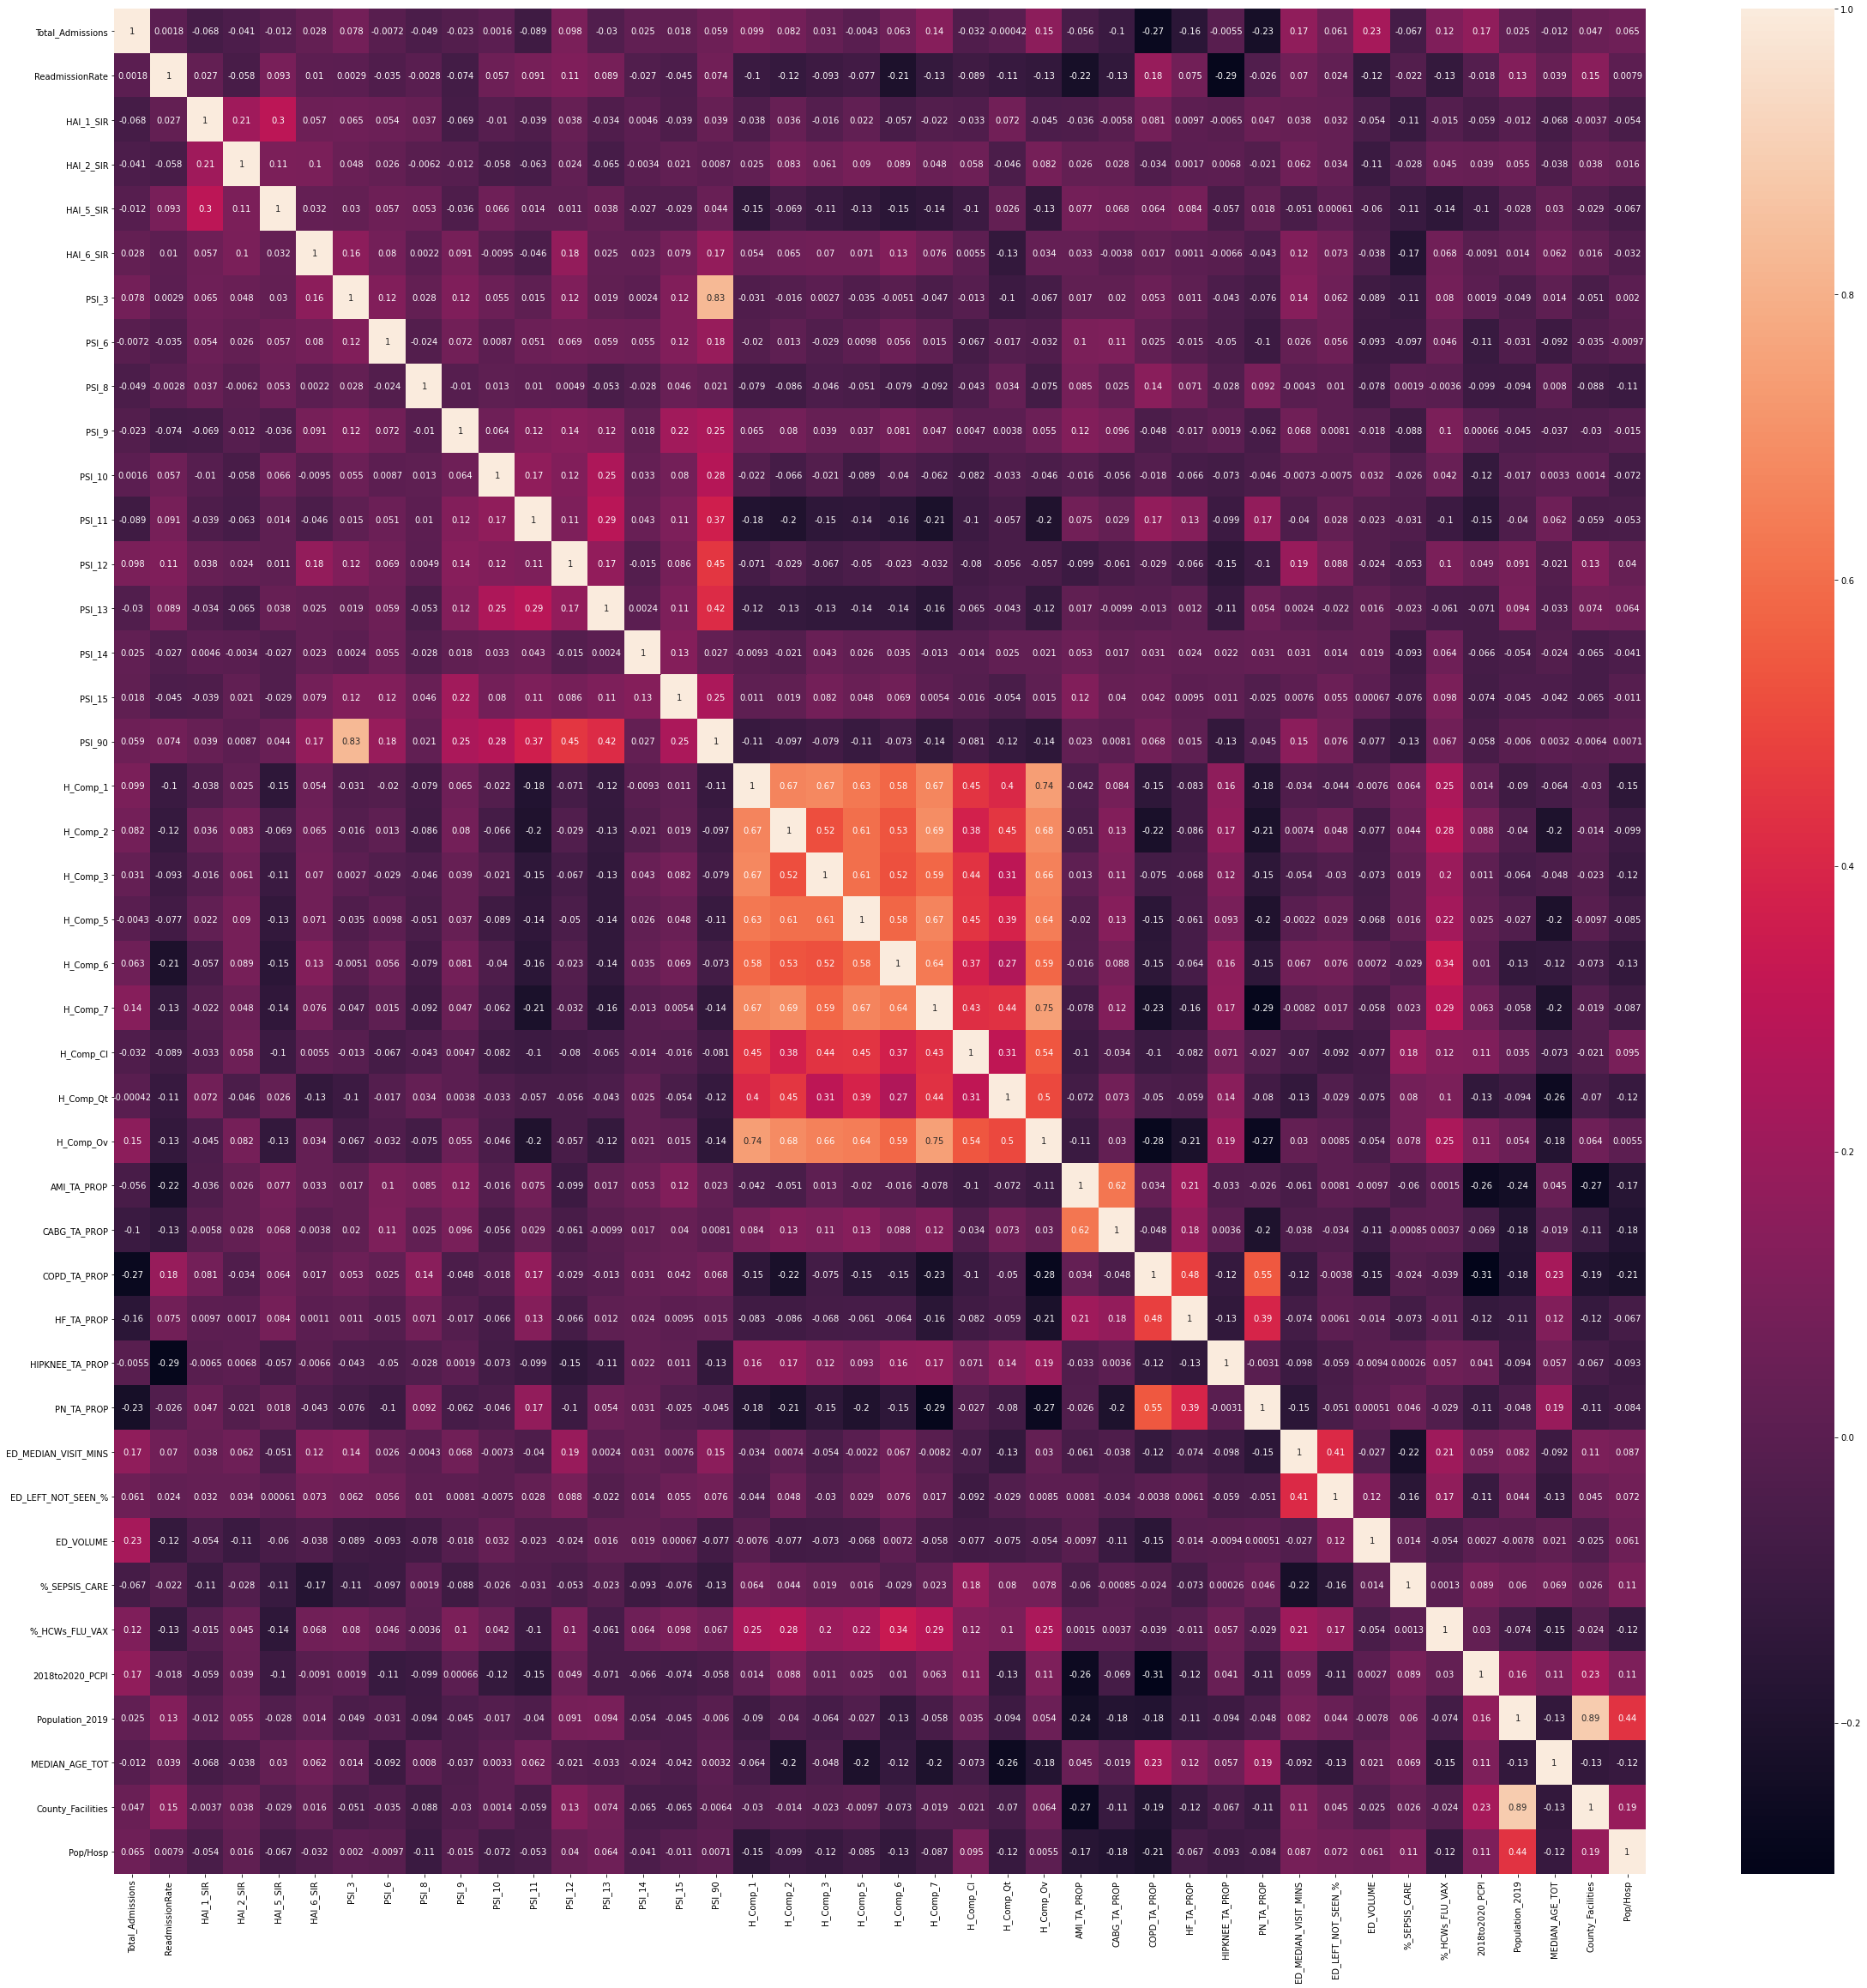

In [18]:
#Heatmap of correlations in main_data
plt.subplots(figsize=(40,40))
sns.heatmap(main_data2.corr(), annot = True);

One thing that pops out immediately on a heatmap is that the H_Comp features (patient survey star ratings) are highly correlated with each other for the most part. This is especially true of the overall hospital rating ('H_Comp_Ov') relative to the component patient survey star ratings. So, at least for the visualization and overall EDA, we will move forward with just H_Comp_Ov from this set of related measures. 

In [19]:
#Create a new df minus the highly correlated component patient survey star rating features
main_data3 = main_data2.drop(['H_Comp_1','H_Comp_2','H_Comp_3','H_Comp_5','H_Comp_6','H_Comp_7','H_Comp_Cl','H_Comp_Qt'], axis=1)
main_data3.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1006 entries, 0 to 1005
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Facility_ID           1006 non-null   object 
 1   City                  1006 non-null   object 
 2   State                 1006 non-null   object 
 3   County                1006 non-null   object 
 4   Total_Admissions      1006 non-null   int64  
 5   ReadmissionRate       1006 non-null   float64
 6   HAI_1_SIR             992 non-null    float64
 7   HAI_2_SIR             994 non-null    float64
 8   HAI_5_SIR             943 non-null    float64
 9   HAI_6_SIR             947 non-null    float64
 10  PSI_3                 1005 non-null   float64
 11  PSI_6                 1005 non-null   float64
 12  PSI_8                 1005 non-null   float64
 13  PSI_9                 1005 non-null   float64
 14  PSI_10                996 non-null    float64
 15  PSI_11               

<AxesSubplot:>

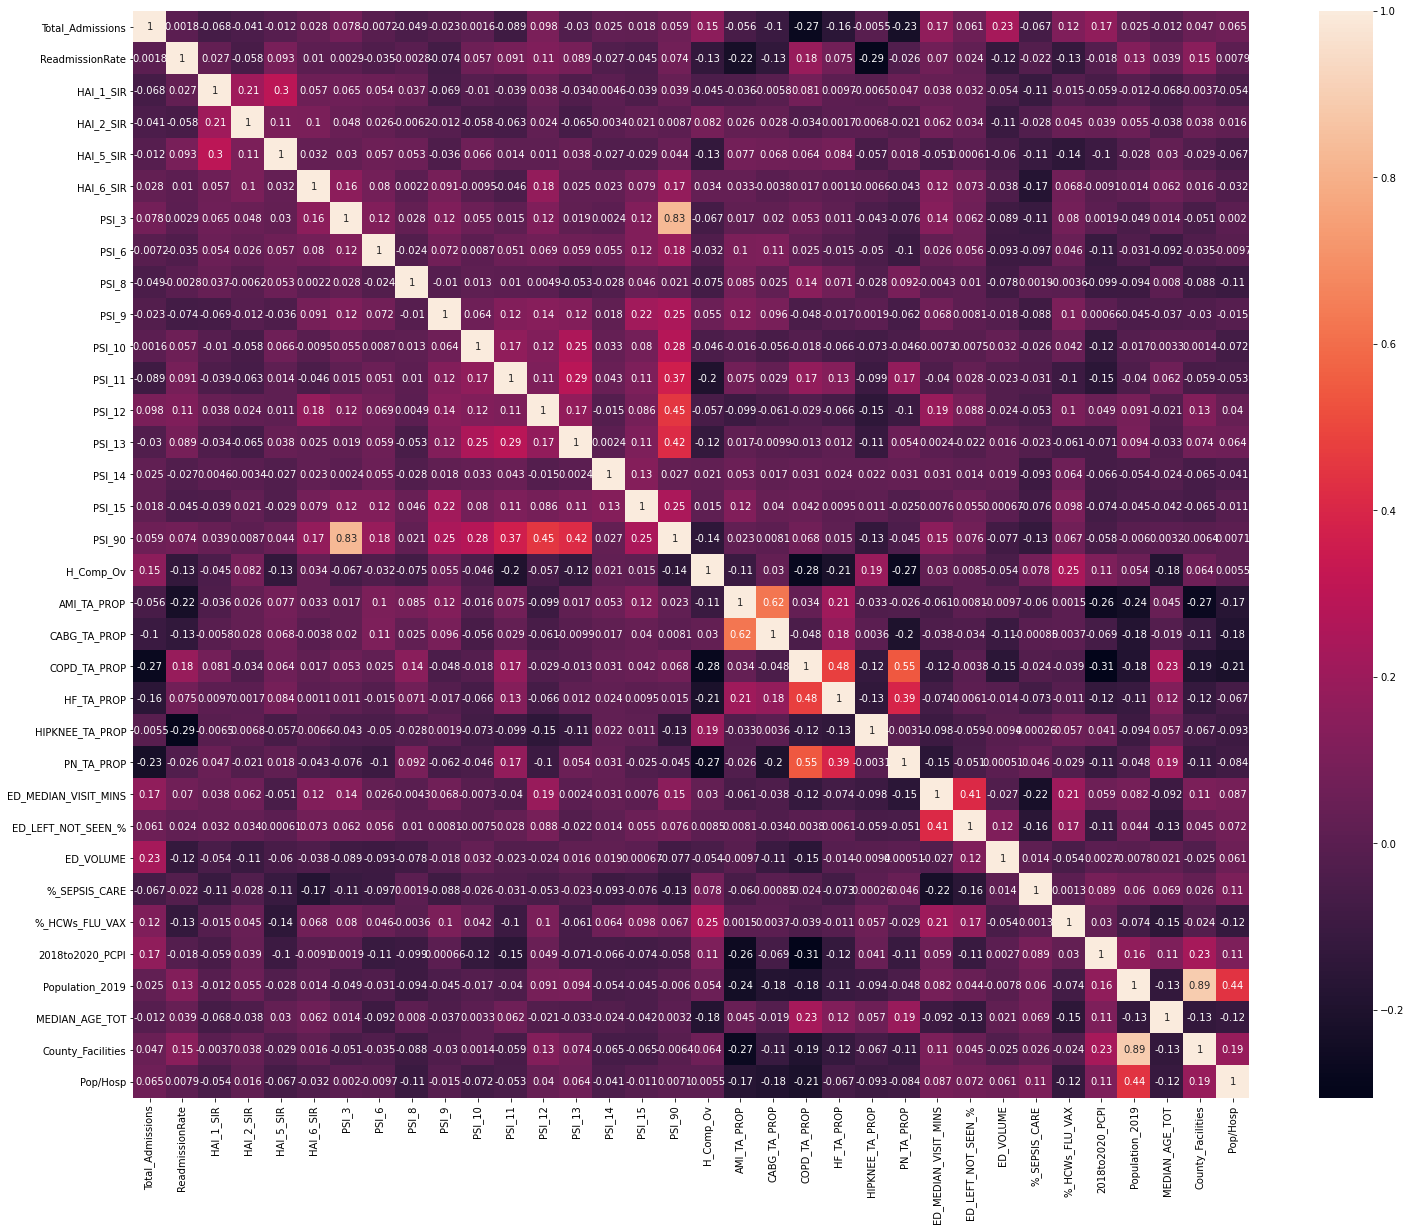

In [20]:
#Recreate Heatmap with the large number of highly correlated patient survey features removed
plt.subplots(figsize=(25,20))
sns.heatmap(main_data3.corr(), annot = True)

We see from the heat map that our target feature doesn't have a particularly strong correlation to any of the individual putative predictive features. 
* The strongest positive correlation that we do see (0.18) is with % Initial Inpatient Admissions Due to COPD (COPD_TA_PROP). So perhaps hospitals taking in a higher proportion of patients with breathing issues are more likely to see readmissions. 
* Number of inpatient facilities in the county where a given inpatient facility is located (County_Facilities) had a small positive correlation with readmission rate (0.15). However, there is no apparent strong relationship between number of facilities per person at the county level and readmission rate.
* 'Population_2019' came in as the second highest positive correlation (0.13), so perhaps being in a high population environment makes it more likely that patients are readmitted via some intermediary mechanism. 
* Finally, there is a modest positive correlation (0.11) between perioperative pulmonary embolism or deep vein thrombosis rate (PSI-12) and readmission rate. So, it may be that such an incident occuring during the hospital stay may increase the liklihood of readmission.

There are a few reasonably strong negative correlations in the data as well. 
* At .29, is % Initial Inpatient Admissions Due to Hip/Knee Replacement ('HIPKNEE_TA_PROP'). This is an indication that case mix is related to readmission rate. Here, it could be that hip/knee replacement patients are less likely to be readmitted relative to other case types. So a hospital with a low case load for this type of procedure might have a higher readmission rate because they take on a higher proportion of cases with a higher chance of readmission. 
* Another negative correlation of note (-0.22) for our target feature is % Initial Inpatient Admissions Due to AMI (AMI_TA_Prop). As with the previous feature, this could mean that hospitals taking on a lower relative load of this type of case could have a higher rate of readmission because they are taking in a higher proportion of cases more associated with higher risk of readmission. 
* There is a modest negative correlation (-.11) of % Initial Inpatient Admissions Due to CABG ('CABG_TA_PROP'). So this case type be relatively non-associated with readmission
* Finally, there is a modest negative correlation (-.13) between Readmission Rate and patient rating of initial inpatient visit (H_Comp_Ov).

In [21]:
#Let's look at some scatter plots of putative predictive features relative to our target feature (readmission rate)
#Function to create scatterplots of target feature vs putative predictive features
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'ReadmissionRate', data=main_data3, alpha=0.5)
        ax.set(xlabel=col, ylabel='Readmission Rate')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [22]:
#Exclude non-numeric features from plots
features = [x for x in main_data3.columns if x not in ['Facility_ID', 'City', 'State', 'County']]

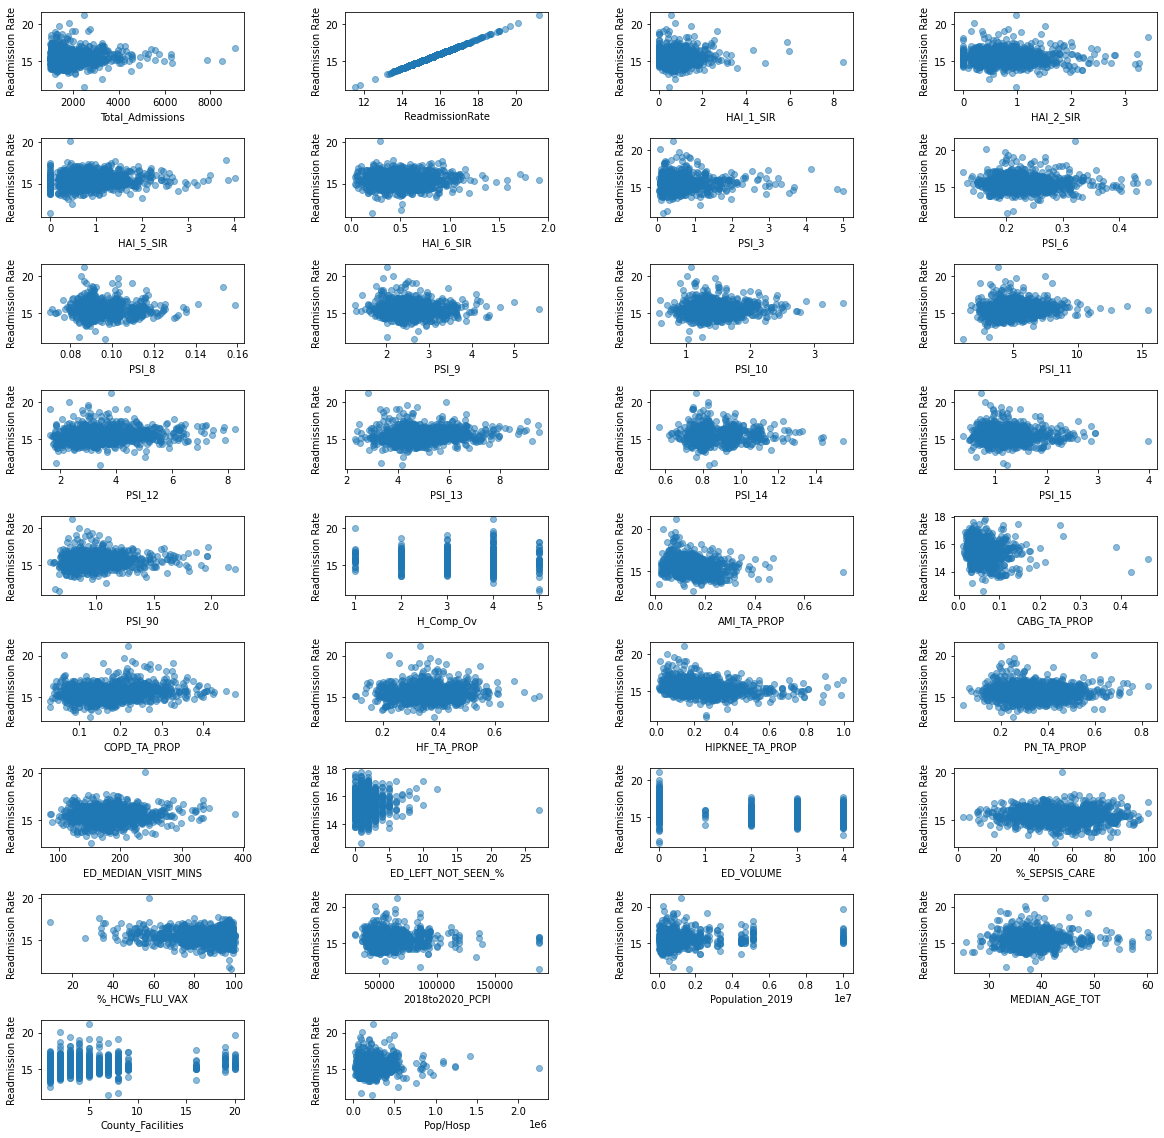

In [23]:
#Plot the putative predictive features vs target feature
scatterplots(features, ncol=4, figsize=(20, 20))

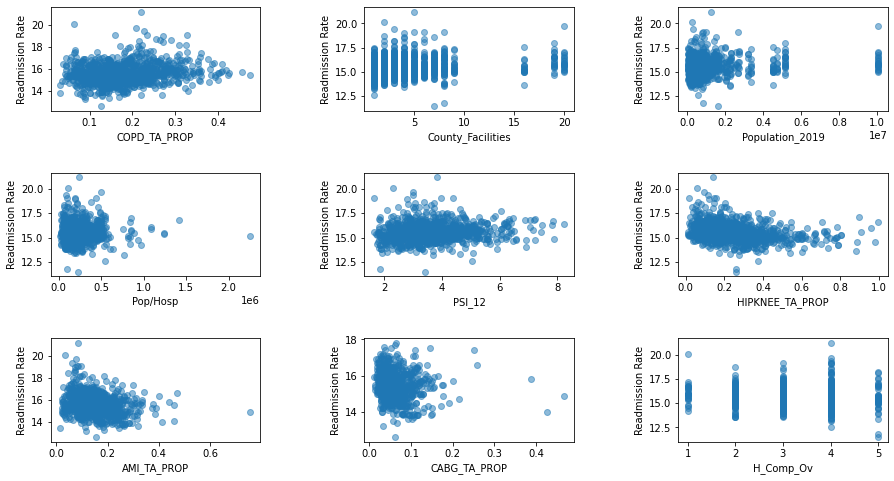

In [24]:
#Let's look at some scatterplots just of the features we identified as having some correlation to the target (and our new Pop/Hosp feature)
scatterplots(['COPD_TA_PROP','County_Facilities','Population_2019', 'Pop/Hosp','PSI_12','HIPKNEE_TA_PROP','AMI_TA_PROP','CABG_TA_PROP','H_Comp_Ov'], ncol=3)

### 6. Saving Data

In [25]:
#Saving data
main_data3.to_csv('../data/main_df_post2.csv', index=False)

### 7. EDA Conclusions
We saw already that our target feature doesn't have a particularly strong correlation to any of the individual putative predictive features. 
* The strongest positive correlation that we do see (0.18) is with % Initial Inpatient Admissions Due to COPD (COPD_TA_PROP). So perhaps hospitals taking in a higher proportion of patients with breathing issues are more likely to see readmissions.
* Number of inpatient facilities in the county where a given inpatient facility is located (County_Facilities) had a small positive correlation with readmission rate (0.15). However, there is no apparent strong relationship between number of facilities per person at the county level and readmission rate (Pop/Hosp).
    - We added these two features during the EDA to get a better sense of how facility availability may influence RR.
* 'Population_2019' came in as the second highest positive correlation (0.13), so perhaps being in a high population environment makes it more likely that patients are readmitted via some intermediary mechanism. 
* Finally, there is a modest positive correlation (0.11) between perioperative pulmonary embolism or deep vein thrombosis rate (PSI-12) and readmission rate. So, it may be that such an incident occuring during the hospital stay may increase the liklihood of readmission.

There are a few reasonably strong negative correlations in the data as well. 
* At -.29, is % Initial Inpatient Admissions Due to Hip/Knee Replacement ('HIPKNEE_TA_PROP'). This is an indication that case mix is related to readmission rate. Here, it could be that hip/knee replacement patients are less likely to be readmitted relative to other case types. So a hospital with a low case load for this type of procedure might have a higher readmission rate because they take on a higher proportion of cases with a higher chance of readmission. 
* Another negative correlation of note (-0.22) for our target feature is % Initial Inpatient Admissions Due to AMI (AMI_TA_Prop). As with the previous feature, this could mean that hospitals taking on a lower relative load of this type of case could have a higher rate of readmission because they are taking in a higher proportion of cases more associated with higher risk of readmission. 
* There is a modest negative correlation (-.11) of % Initial Inpatient Admissions Due to CABG ('CABG_TA_PROP'). So this case type be relatively non-associated with readmission.
* Finally, there is a modest negative correlation (-.13) between Readmission Rate and patient rating of initial inpatient visit (H_Comp_Ov). 

Based on the modest correlations at the individual feature level seen in this exploration, it is likely that a more nonlinear model type will bear fruit in prediction of readmission rate (RR). However, we will first look at an average-based "dummy" model and some linear models before progressing to trees and/or boosted trees. 

Data Transformations:
* We numerically encoded 'ED_VOLUME', previously categorical as such: 0=Missing; 1=low; 2=medium; 3=high; 4=very high